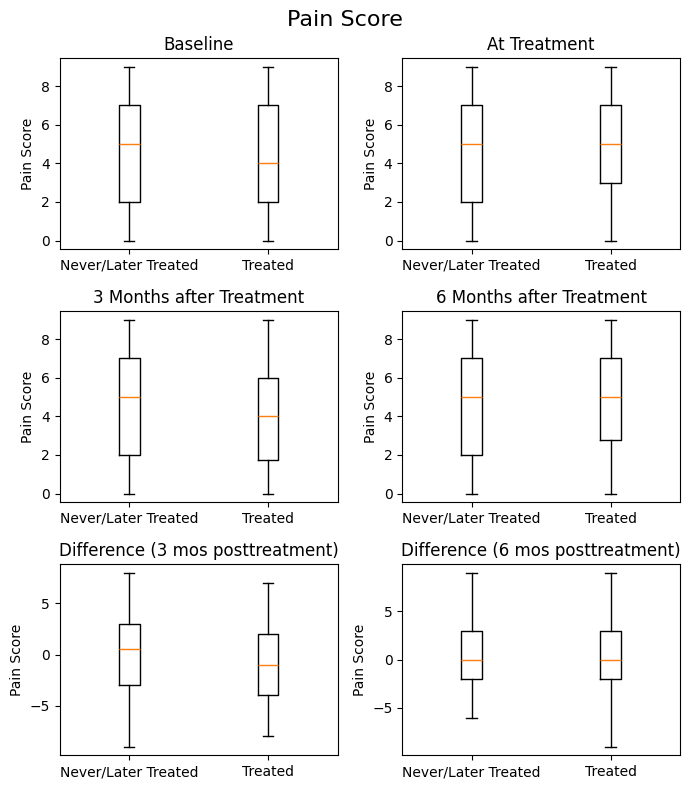

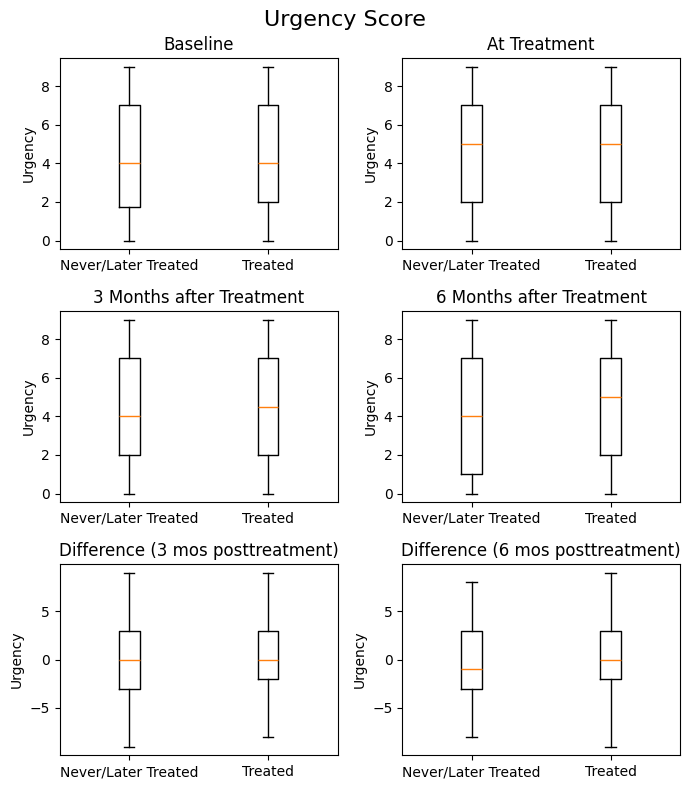

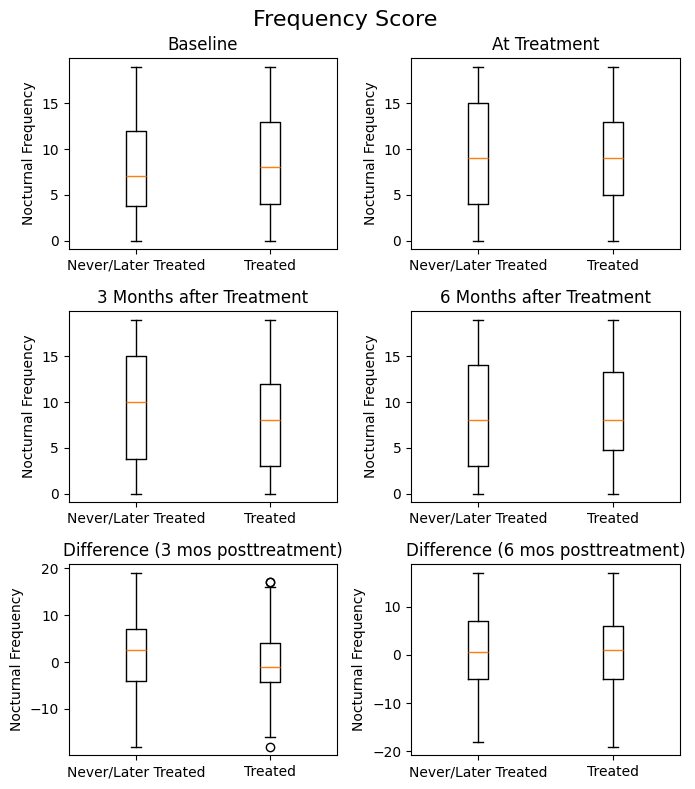

Wilcoxon signed-rank test: statistic=2007.0, p-value=0.0041


In [6]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(28)

# Constants
n_patients = 400
BOX_TITLES = [
    'Baseline', 'At Treatment', '3 Months after Treatment', 
    '6 Months after Treatment', 'Difference (3 mos posttreatment)', 
    'Difference (6 mos posttreatment)'
]
BOX_LABELS = ['Never/Later Treated', 'Treated']

# Generate synthetic data
df = pd.DataFrame({
    'patient_id': np.arange(n_patients),
    'gender': np.random.choice(['M', 'F'], n_patients),
    'treatment_time': np.random.choice([6, 9, 12, np.nan], n_patients),
    'pain_baseline': np.random.randint(0, 10, n_patients),
    'urgency_baseline': np.random.randint(0, 10, n_patients),
    'frequency_baseline': np.random.randint(0, 20, n_patients),
    'pain_treatment': np.random.randint(0, 10, n_patients),
    'urgency_treatment': np.random.randint(0, 10, n_patients),
    'frequency_treatment': np.random.randint(0, 20, n_patients),
    'pain_3m': np.random.randint(0, 10, n_patients),
    'urgency_3m': np.random.randint(0, 10, n_patients),
    'frequency_3m': np.random.randint(0, 20, n_patients),
    'pain_6m': np.random.randint(0, 10, n_patients),
    'urgency_6m': np.random.randint(0, 10, n_patients),
    'frequency_6m': np.random.randint(0, 20, n_patients),
    'outcome': np.random.normal(0, 1, n_patients),
})

# Split into treated and not treated
treated = df[df['treatment_time'].notna()].copy()
not_treated = df[df['treatment_time'].isna()].copy()

# Define covariates for matching
cov_cols = ['pain_baseline', 'urgency_baseline', 'frequency_baseline',
            'pain_treatment', 'urgency_treatment', 'frequency_treatment']

# Compute Mahalanobis distance matrix
cov_matrix = df[cov_cols].cov().values
cov_inv = np.linalg.inv(cov_matrix)

def mahalanobis_distance(x, y, cov_inv):
    return np.sqrt(np.dot(np.dot((x - y), cov_inv), (x - y).T))

treated_matrix = treated[cov_cols].values
not_treated_matrix = not_treated[cov_cols].values
distance_matrix = cdist(treated_matrix, not_treated_matrix, metric=lambda u, v: mahalanobis_distance(u, v, cov_inv))

# Solve optimal assignment problem
treated_indices, control_indices = linear_sum_assignment(distance_matrix)

# Get matched datasets
matched_treated = treated.iloc[treated_indices].copy()
matched_not_treated = not_treated.iloc[control_indices].copy()

# Compute differences for each matched pair
for period in ['3m', '6m']:
    for measure in ['pain', 'urgency', 'frequency']:
        matched_treated[f"{measure}_diff_{period}"] = matched_treated[f"{measure}_{period}"] - matched_treated[f"{measure}_baseline"]
        matched_not_treated[f"{measure}_diff_{period}"] = matched_not_treated[f"{measure}_{period}"] - matched_not_treated[f"{measure}_baseline"]

# Function to create a combined figure with 6 box plots
def plot_combined_boxplots(data_treated, data_not_treated, measure_names, title, label):
    fig, axes = plt.subplots(3, 2, figsize=(7, 8))
    fig.suptitle(title, fontsize=16)
    
    for i, measure in enumerate(measure_names):
        row, col = divmod(i, 2)
        axes[row, col].boxplot([data_not_treated[measure], data_treated[measure]], tick_labels=BOX_LABELS)
        axes[row, col].set_title(BOX_TITLES[i])
        axes[row, col].set_ylabel(label)

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

# Generate combined boxplots for Pain, Urgency, and Frequency
plot_combined_boxplots(
    matched_treated, matched_not_treated, 
    ['pain_baseline', 'pain_treatment', 'pain_3m', 'pain_6m', 'pain_diff_3m', 'pain_diff_6m'], 
    "Pain Score", "Pain Score"
)

plot_combined_boxplots(
    matched_treated, matched_not_treated, 
    ['urgency_baseline', 'urgency_treatment', 'urgency_3m', 'urgency_6m', 'urgency_diff_3m', 'urgency_diff_6m'], 
    "Urgency Score", "Urgency"
)

plot_combined_boxplots(
    matched_treated, matched_not_treated, 
    ['frequency_baseline', 'frequency_treatment', 'frequency_3m', 'frequency_6m', 'frequency_diff_3m', 'frequency_diff_6m'], 
    "Frequency Score", "Nocturnal Frequency"
)

# Wilcoxon test
treated_outcomes = matched_treated['outcome'].values
not_treated_outcomes = matched_not_treated['outcome'].values
stat, p_value = wilcoxon(treated_outcomes, not_treated_outcomes)
print(f"Wilcoxon signed-rank test: statistic={stat}, p-value={p_value:.4f}")
